In [1]:
import tensorflow as tf
print('Using Tensorflow '+tf.__version__)
assert tf.__version__>='1.0.0', ('You should use Tensorflow 1.0 or superior')
import matplotlib;
from PIL import Image
#matplotlib.use('Agg')
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
import os.path
import csv
import numpy as np

from src.argparse import argparse
from src.region_to_bbox import region_to_bbox
from src.pprint_params import pprint_params
from src.Tracker import Tracker
from src.crops import *
from src.siamese import import_siamese

Using Tensorflow 1.1.0


In [2]:
hp = {"z_lr":0}
evaluation = {"video": "vot2016_helicopter"}
run = {"visualization":1,"debug":0}
hp,evaluation,run,env,design = argparse(hp, evaluation, run)

In [3]:
video_folder = os.path.join(env.root_dataset, evaluation.dataset, evaluation.video)
frame_name_list = [f for f in os.listdir(video_folder) if f.endswith(".jpg")]
frame_name_list = [os.path.join(env.root_dataset, evaluation.dataset, evaluation.video, '') + s for s in frame_name_list]
frame_name_list.sort()
num_frames = np.size(frame_name_list)

with Image.open(frame_name_list[0]) as img:
    frame_sz = np.asarray(img.size)
    frame_sz[1], frame_sz[0] = frame_sz[0], frame_sz[1]

In [4]:
gt_file = os.path.join(video_folder, 'groundtruth.txt')
gt = np.genfromtxt(gt_file, delimiter=',')
assert len(gt) == len(frame_name_list), ('Number of frames and number of GT lines should be equal.')
# bbox is in format <cx,cy,w,h>
init_bbox = region_to_bbox(gt[evaluation.start_frame])
bboxes = np.zeros((num_frames,4)) # stores tracker's output for evaluation
# create an instance of the class Tracker and initialize it with groundtruth
tracker = Tracker(init_bbox, design)
# fixed multiplicative factors to scale up/down the target
scale_factors = hp.scale_step**np.linspace(-np.ceil(hp.scale_num/2), np.ceil(hp.scale_num/2), hp.scale_num)
scaled_exemplar = scale_factors * tracker.z_sz
min_z = hp.scale_min * tracker.z_sz
max_z = hp.scale_max * tracker.z_sz
min_x = hp.scale_min * tracker.x_sz
max_x = hp.scale_max * tracker.x_sz

In [5]:
#### BUILD THE TF GRAPH #####

# Make a queue of file names
filename_queue = tf.train.string_input_producer(frame_name_list, shuffle=False, capacity=num_frames)

image_reader = tf.WholeFileReader()
# Read a whole file from the queue
_, image_file = image_reader.read(filename_queue)

# Decode the image as a JPEG file, this will turn it into a Tensor
image = tf.cast(tf.image.decode_jpeg(image_file), tf.int32)

# used to pad the crops
avg_chan = tf.cast(tf.reduce_mean(image, axis=(0,1)), tf.int32)

frame_padded, npad = pad_frame(image, frame_sz, tracker.bbox.pos, tracker.z_sz, avg_chan);

# z_crops = extract_crops(tracker.frame_padded, tracker.npad, tracker.bbox.pos, tracker.z_sz, design.exemplar_sz)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer, input_producer/Identity)]]

Caused by op u'input_producer/input_producer_EnqueueMany', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
 

ValueError: setting an array element with a sequence.

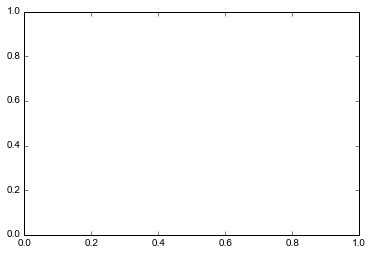

In [6]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    # Coordinate the loading of image files.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Get an image tensor from the queue
    for i in xrange(1):
        im = sess.run([frame_padded])
        if run.visualization:
            im_ = np.squeeze(im, axis=0)
            fig = plt.figure(1)
            ax = fig.add_subplot(111)
            ax.imshow(np.uint8(im_))
            plt.ion()
            plt.show()
            plt.pause(0.001)

    # Finish off the filename queue coordinator.
    coord.request_stop()
    coord.join(threads) 